In [1]:
import sys
sys.path.append('../src')
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from scipy.special import erfinv
from sklearn.decomposition import DictionaryLearning
from utils import *
from classes import *
rng = np.random.default_rng()

In [2]:
MODEL = 'EI-E2I2E'
# MODEL = 'EI-HVC2E'
# MODEL = 'EI-E2E'

In [3]:
fname = '../realistic_auditory_processing/learned_song_responses.npz'
T_SONG = np.load(fname)['ctrl'].shape[2] # (n_songs, N, T)

In [4]:
adult = dict(np.load('../adult_songs/data.npz'))
n_samples, n_syl, n_freq_bins, n_time_bins = adult['spec_syl'].shape
# xmin = adult['spec_syl'].min(axis=(0,2,3), keepdims=True) # syl-wise norm
# xmax = adult['spec_syl'].max(axis=(0,2,3), keepdims=True)
# adult['spec_syl'] = (adult['spec_syl'] - xmin) / (xmax - xmin)

In [5]:
n_basis = 20
basis = np.zeros((n_basis, n_freq_bins*n_time_bins))
coefs = np.zeros((n_samples*n_syl, n_basis))
dl = DictionaryLearning(n_components=n_basis, alpha=0.1, fit_algorithm='cd', 
                        positive_code=True, positive_dict=True)
aux = np.concatenate([adult['spec_syl'][:,i].reshape(n_samples, -1) 
                      for i in range(n_syl)])
coefs = dl.fit_transform(aux)
a_std = coefs.std(axis=0)[None,:]
coefs/= a_std
basis = dl.components_ * a_std.T

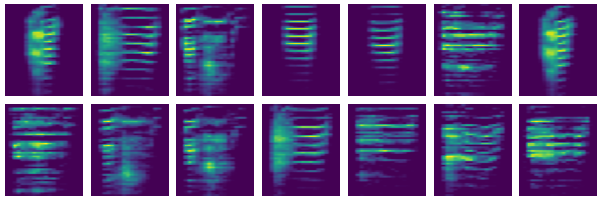

In [6]:
fig, ax = plt.subplots(2, 7, figsize=(6, 2))
ax = ax.flatten()
for i, b in enumerate(basis):
    if i >= len(ax):
        break
    ax[i].imshow(b.reshape(n_freq_bins, n_time_bins))
    ax[i].set_axis_off()

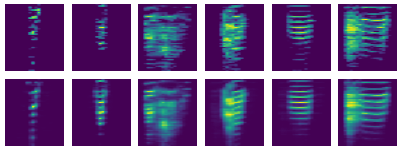

In [7]:
_ = coefs @ basis
fig, ax = plt.subplots(2, n_syl, figsize=(4, 1.5))
for i in range(n_syl):
    j = rng.integers(0,n_samples)
    ax[0,i].imshow(adult['spec_syl'][j,i])
    ax[1,i].imshow(_[i*n_samples+j].reshape(n_freq_bins, n_time_bins))
    ax[0,i].set_axis_off()
    ax[1,i].set_axis_off()

In [8]:
env = Environment(basis, n_time_bins, T_SONG, 
                  adult['syl_on'].mean(axis=0).astype(int), 
                  adult['syl_off'].mean(axis=0).astype(int),
                  '../realistic_auditory_processing/net_params.pkl', 
                  '../results/', MODEL)

In [9]:
agent = ActorCritic(n_syl, env.action_dim)

optimizer = torch.optim.Adam(agent.parameters(), lr=1e-2)

In [10]:
actor_losses, critic_losses = [], []
total_rewards, advantages, ve_rates = [], [], []
actions, songs, song_embs = [], [], []

batch = 1

for epoch in tqdm(range(2000)):
    if epoch % batch == 0:
        actor_loss, critic_loss = 0, 0
        optimizer.zero_grad()
    
    action, val, log_prob, entropy = agent()
    action[action<2] = 0
    bos, song_emb, rE = env.step(action)
    bos_ = env._perform(action)[0]
    
    if epoch == 0 or (epoch+1) % 100 == 0:
        songs.append(bos_)
        song_embs.append(song_emb)

    # baseline subtraction; the rE here also includes the burning period from 0 to T_burn
    rewards = [rE[env.t0[t]:env.t0[t]+120].mean() for t in range(n_syl)]
    rewards = np.array(rewards)
    total_rewards.append(np.mean(rewards))
    ve_rates.append(-rE.mean())

    advantage = torch.tensor(rewards) - val
    critic_loss += (advantage**2).sum()
    actor_loss += -(log_prob * advantage.detach()).sum()

    if (epoch+1) % batch == 0:
        actor_losses.append(actor_loss.item())
        critic_losses.append(critic_loss.item())
        entropy_weight = 0.05
        l1 = agent.l1(0)
        loss = actor_loss + critic_loss - entropy * entropy_weight + l1
        loss.backward()
        optimizer.step()
    
    advantages.append(advantage.detach().sum())

100%|███████████████████████████████████████| 2000/2000 [08:46<00:00,  3.80it/s]


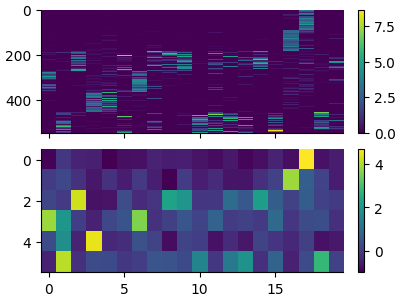

In [11]:
fig, ax = plt.subplots(2, figsize=(4,3), sharex='all')
im = ax[0].imshow(coefs, interpolation='none')
plt.colorbar(im, ax=ax[0])
im = ax[1].imshow(agent.actor_mean.data)#, vmin=0, vmax=1)
plt.colorbar(im, ax=ax[1])

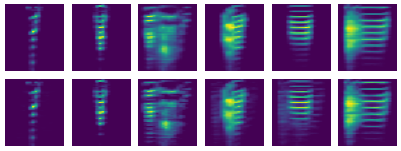

In [12]:
fig, ax = plt.subplots(2, n_syl, figsize=(4, 1.5))
for i in range(n_syl):
    ax[0,i].imshow(adult['spec_syl'][:,i].mean(axis=0))
    ax[1,i].imshow(songs[-1][i])
    ax[0,i].set_axis_off()
    ax[1,i].set_axis_off()

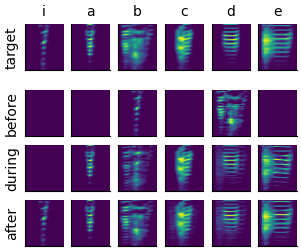

In [13]:
fig, ax = plt.subplots(4, n_syl, figsize=(3, 2.5))
for i, t in enumerate('iabcde'):
    ax[0,i].imshow(adult['spec_syl'][:,i].mean(axis=0))
    ax[1,i].imshow(songs[0][i])
    ax[2,i].imshow(songs[10][i])
    ax[3,i].imshow(songs[-1][i])
    for k in range(4):
        ax[k,i].set(xticks=[], yticks=[])
    ax[0,i].set_title(t)#, weight='bold' if i > 1 else 'normal')
ax[1,0].set_title(' ', fontsize=3)
for i, y in enumerate(('target', 'before', 'during', 'after')):
    ax[i,0].set(ylabel=y)
if MODEL == 'EI-E2I2E':
    fig.savefig('../svg/rl_results.svg')
else:
    fig.savefig('../svg/supplementary/rl_results_%s.svg' % MODEL)

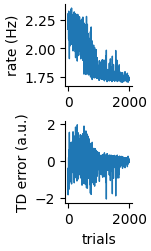

In [14]:
fig, ax = plt.subplots(2, figsize=(1.5,2.5))
ax[0].plot(ve_rates, lw=1)
ax[1].plot(advantages, lw=1)
ax[0].set(ylabel='rate (Hz)')
ax[1].set(ylabel='TD error (a.u.)', xlabel='trials')
if MODEL == 'EI-E2I2E':
    fig.savefig('../svg/rl_mean_err.svg')
else:
    fig.savefig('../svg/supplementary/rl_mean_err_%s.svg' % MODEL)